In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json

from signature.signature.tensor_algebra import TensorAlgebra
from signature.signature.tensor_sequence import TensorSequence

from pricing.pricing.models.sig_vol import SigVol
from pricing.pricing.products.vanilla_option import VanillaOption
from pricing.pricing.models.model_params import LewisParams, MCParams
from pricing.pricing.utility import from_1_delta_call_to_strike

from simulation.monte_carlo import MonteCarlo

my_green = "#5b6c64"
my_copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"]) 

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [2]:
%%time
ta = TensorAlgebra(dim=2, trunc=5)

Compiling...
Compilation finished.
CPU times: total: 4min 52s
Wall time: 5min 23s


In [5]:
N = 5
e0 = ta.from_dict({"": 1}, trunc=N)
e1 = ta.from_dict({"1": 1}, trunc=N)
e2 = ta.from_dict({"2": 1}, trunc=N)
e11 = ta.from_dict({"11": 1}, trunc=N)
e12 = ta.from_dict({"12": 1}, trunc=N)
e21 = ta.from_dict({"21": 1}, trunc=N)
e22 = ta.from_dict({"22": 1}, trunc=N)
e222 = ta.from_word("222", trunc=N)
e221 = ta.from_word("221", trunc=N)
e121 = ta.from_word("121", trunc=N)
e211 = ta.from_word("211", trunc=N)
e2222 = ta.from_word("2222", trunc=N)
e22222 = ta.from_word("22222", trunc=N)

In [6]:
rho = -0.5

vol_ts = e0 * 0.2 + e2 * 0.1 + e12 * 0.1 + e21 * 0.1 + e22 * 0.1

ta.print(vol_ts)

model = SigVol( 
    vol_ts=vol_ts, 
    ta=ta, 
    rho=rho
)

0.2*∅ + 0.1*2 + 0.1*12 + 0.1*21 + 0.1*22


## To Do:
- Implement localization for Malliavin ✅
- Implement delta from CF ✅
- Implement conditioning trick ✅
- Implement $D_s \Sigma_t$
- Implement formulae using $D^W$
  
## To test:
- Standard case (big TTM, rho ~ -0.5)
- Short maturities
- Correlations close to -1
- Compare for vanilla calls and digital calls


Text(0.5, 1.0, 'Vol trajectories')

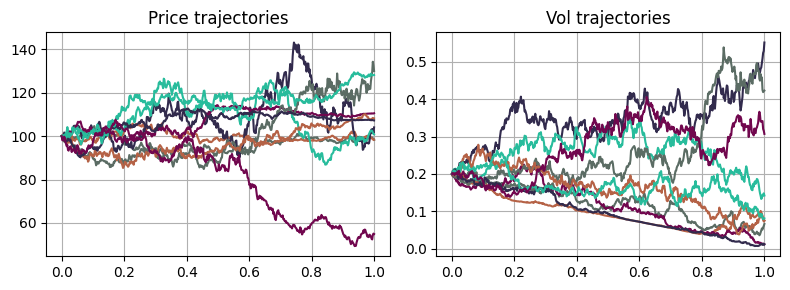

In [7]:
T = 1
F0 = 100

size = 10
N_grid = 500

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=42)
prices, vols = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, return_vol=True)
prices

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for price, vol in zip(prices, vols):
    ax[0].plot(t_grid, price)
    ax[1].plot(t_grid, vol)
ax[0].set_title("Price trajectories")
ax[1].set_title("Vol trajectories")

In [8]:
%%time
size = 10**4

rng = np.random.default_rng(seed=21)
prices, vols, bm, sig = model.get_price_trajectory(t_grid=t_grid, size=size, F0=F0, rng=rng, 
                                                   return_vol=True, return_bm=True, return_sig=True)

rho_bar = np.sqrt(1 - model.rho**2)

B = bm[:, 0, :]
W = bm[:, 1, :]
W_ort = (B - model.rho * W) / rho_bar

CPU times: total: 10.4 s
Wall time: 13.9 s


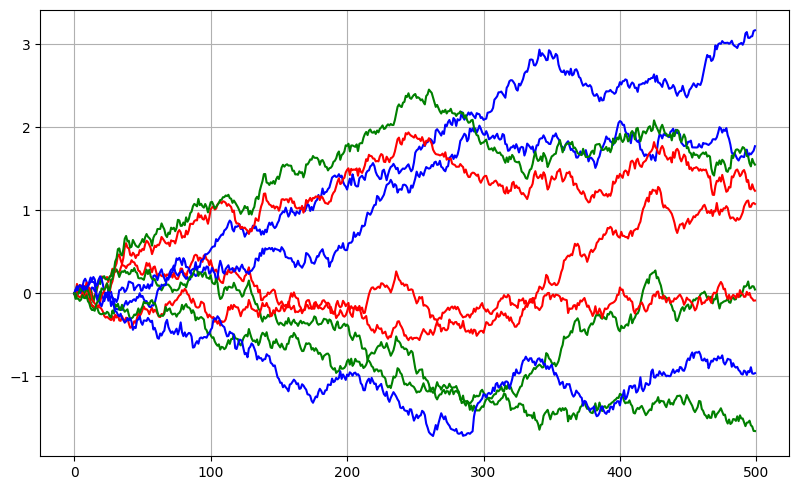

In [9]:
for i in range(3):
    plt.plot(W_ort[i], "r")
    plt.plot(W[i], "b")
    plt.plot(B[i], "g")

In [10]:
from scipy.stats import norm

def call_payoff(F, K):
    return np.maximum(F - K, 0)

def digital_call_payoff(F, K):
    return (F - K >= 0).astype(float)

## Localization (Vanilla Call)

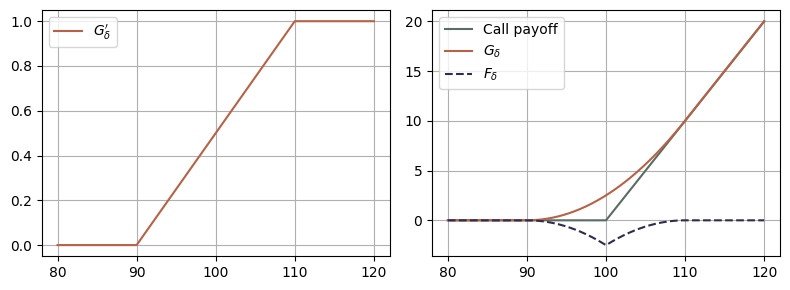

In [11]:
delta = 10
F_grid = np.linspace(80, 120, 1000)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))

H_delta = lambda x, K: (x - (K - delta)) / (2 * delta) * (x >= K - delta) * (x <= K + delta) + (x > K + delta)
F_delta = lambda x, K: (-(x - (K - delta))**2 / (4 * delta)) * (x >= K - delta) * (x < K) + \
                       (-(x - (K + delta))**2 / (4 * delta)) * (x >= K) * (x < K + delta)

ax[0].plot(F_grid, H_delta(F_grid, K=F0), label="$G_\delta'$", color=my_copper)
ax[0].legend()


ax[1].plot(F_grid, call_payoff(F_grid, K=F0), label="Call payoff")
ax[1].plot(F_grid, np.cumsum(H_delta(F_grid, K=F0) * (F_grid[1] - F_grid[0])), label="$G_\delta$")
ax[1].plot(F_grid, F_delta(F_grid, K=F0), "--", label="$F_\delta$")

ax[1].legend()

## Computing Delta of ATM vanilla call option

In [12]:
confidence = 0.95

### Characteristic function

In [13]:
%%time

from scipy.special import roots_laguerre

N_points = 60

maturity = T
strikes = np.array([F0])
k = np.log(F0 / strikes)
z_arr, w_arr = roots_laguerre(n=N_points)

z_arr = np.reshape(z_arr, (-1, 1))
integrand_arr = (1j * (z_arr - 0.5 * 1j) * np.exp(1j * (z_arr - 1j / 2) * k.reshape((1, -1))) * (
        model.characteristic_function(T=maturity, x=0, u1=z_arr - 1j / 2).reshape((-1, 1))
) / (z_arr ** 2 + 0.25)).real
integral = (w_arr * np.exp(z_arr.squeeze())) @ integrand_arr

delta_cf = 1 - strikes / F0 / np.pi * integral
print(delta_cf)

mc_cf = MonteCarlo(batch=delta_cf * np.ones(size), confidence_level=confidence)

[0.61440246]
CPU times: total: 33.2 s
Wall time: 45.6 s


### Finite difference with $\epsilon = 1\%$ bump

In [14]:
eps = 0.01
price_bump_plus = prices * (1 + eps)
price_bump_minus = prices * (1 - eps)

In [15]:
batch_fd = (call_payoff(price_bump_plus[:, -1], F0) - call_payoff(price_bump_minus[:, -1], F0)) / (2 * eps * F0)
mc_fd = MonteCarlo(batch=batch_fd, confidence_level=confidence)

### Conditioning + BS Delta

In [16]:
def bs_delta(S0, K, T, sigma, r):
    d_plus = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d_plus)

In [17]:
U = (sig @ ta.shuop.shuffle_pow(model.vol_ts, 2).tensor_prod(e1)).real[-1]
Z = (sig @ (model.vol_ts.tensor_prod(e2) - model.vol_ts.proj("2").tensor_prod(e1) / 2)).real[-1]

sigma_bs = rho_bar * np.sqrt(U / T)
r_bs = (rho * Z - 0.5 * rho**2 * U) / T

batch_delta_bs = bs_delta(S0=F0, K=F0, T=T, sigma=sigma_bs, r=r_bs) * np.exp(r_bs * T)
mc_delta_bs = MonteCarlo(batch=batch_delta_bs, confidence_level=0.95)

In [18]:
mc_delta_bs.results()

'0.61428 ± 0.00454'

### Malliavin $D^\perp$ with $h_t \equiv 1$

In [19]:
weight_1 = W_ort[:, -1] / F0 / rho_bar / (sig @ model.vol_ts.tensor_prod(e1))[-1].real

batch_mal_1 = call_payoff(prices[:, -1], F0) * weight_1
mc_mal_1 = MonteCarlo(batch=batch_mal_1, confidence_level=0.95)

batch_mal_1_loc = F_delta(prices[:, -1], K=F0) * weight_1 + H_delta(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_1_loc = MonteCarlo(batch=batch_mal_1_loc, confidence_level=0.95)

### Malliavin $D^\perp$ with $h_t \equiv \dfrac{1}{\Sigma_t}$

In [20]:
weight_1_over_sigma = np.sum(np.diff(W_ort, axis=1) / vols[:, :-1], axis=1) / (rho_bar * T * F0)

batch_mal_1_over_sigma = call_payoff(prices[:, -1], F0) * weight_1_over_sigma
mc_mal_1_over_sigma = MonteCarlo(batch=batch_mal_1_over_sigma, confidence_level=0.95)

batch_mal_1_over_sigma_loc = F_delta(prices[:, -1], K=F0) * weight_1_over_sigma + H_delta(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_1_over_sigma_loc = MonteCarlo(batch=batch_mal_1_over_sigma_loc, confidence_level=0.95)

### Malliavin $D^\perp$ with $h_t \equiv {\Sigma_t}$

In [21]:
%%time
weight_sigma = np.sum(np.diff(W_ort, axis=1) * vols[:, :-1], axis=1) / U / (rho_bar * F0)

batch_mal_sigma = call_payoff(prices[:, -1], F0) * weight_sigma
mc_mal_sigma = MonteCarlo(batch=batch_mal_sigma, confidence_level=0.95)

batch_mal_sigma_loc = F_delta(prices[:, -1], K=F0) * weight_sigma + H_delta(prices[:, -1], K=F0) * prices[:, -1] / F0
mc_mal_sigma_loc = MonteCarlo(batch=batch_mal_sigma_loc, confidence_level=0.95)

CPU times: total: 0 ns
Wall time: 31.3 ms


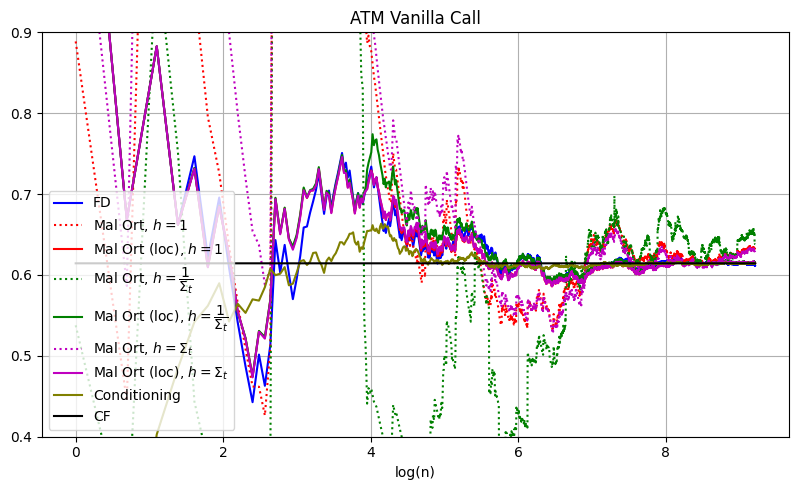

In [22]:
plot_interval = False

fig, ax = plt.subplots()

mc_fd.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, label="FD")

mc_mal_1.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="r", ls=":", label="Mal Ort, $h = 1$")
mc_mal_1_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="r", label="Mal Ort (loc), $h = 1$")

mc_mal_1_over_sigma.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="g", ls=":", label="Mal Ort, $h = \dfrac{1}{\Sigma_t}$")
mc_mal_1_over_sigma_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="g", label="Mal Ort (loc), $h = \dfrac{1}{\Sigma_t}$")

mc_mal_sigma.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="m", ls=":", label="Mal Ort, $h = {\Sigma_t}$")
mc_mal_sigma_loc.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="m", label="Mal Ort (loc), $h = {\Sigma_t}$")

mc_delta_bs.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="olive", label="Conditioning")

mc_cf.convergence_diagram(plot_intervals=plot_interval, log=True, ax=ax, color="k", label="CF")

plt.ylim([0.4, 0.9])
plt.title("ATM Vanilla Call")
plt.show()